# Applications of Machine Learning - Coursework Submission - Notebook for Model 1
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

28th March 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Applications of Machine Learning* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Applications of Machine Learning - Coursework Assignment](../coursework.pdf). The associated report can be found here: [Applications of Machine Learning - Coursework Report](../report/m2_sd2022_report.pdf).

## Set-Up

### Installations & Imports and Settings

In [3]:
!mkdir -p contents
!pip install pandas
!pip install numpy
!pip install typing
!pip install torch
!pip install accelerate
!pip install torchvision
!pip install tqdm
!pip install ipykernel
!pip install ipython
!pip install scipy
!pip install torchmetrics
!pip install matplotlib
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pandas as pd
import shutil
from scipy.stats import entropy
plt.style.use('sd2022.mplstyle')
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_yellow = '#fada5e'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_neongreen = '#0FFF50'
sd2022_neonblue = '#4D4DFF'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
sd2022_bronze =  '#b08d57'

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 1.8 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.8 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp310-cp310-macosx_10_9_x86_64.whl (68 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


## Define Model

### Create Noise Schedule

In [5]:
# Linear Noise schedule 
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}


### Define CNN

In [6]:
# CNN Block
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm((out_channels, *expected_shape)),
            act()
        )

    def forward(self, x):
        return self.net(x)

# CNN Model 
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

### Diffusion Model

In [7]:
# DDPM Model
class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_schedules(betas[0], betas[1], n_T)

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t

        self.n_T = n_T
        self.criterion = criterion

    # Include a function to output z_t
    def forward_show(self, t, x: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(x)
        alpha_t = self.alpha_t[t, None, None, None]
        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        return z_t

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Algorithm 18.1 in Prince"""
        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting
        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t

### Hyperparameters

In [8]:
# CNN hyperparameters
n_hidden = (16, 32, 32, 16) 
activation = nn.GELU

# DDPM hyperparameters
betas = (1e-4, 0.02) 
n_T = 1000

# Training hyperparameters
learning_rate = 2e-4

# Model and optimizer
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=n_hidden, act=activation)
ddpm = DDPM(gt=gt, betas=betas, n_T=n_T)
optim = torch.optim.Adam(ddpm.parameters(), lr=learning_rate)

## MNIST Data

### Training and Validation Data Loader

In [10]:
# Data loaders
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("../data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

# Define the sizes for training and validation sets
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Perform the split
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Create DataLoader for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

# Create DataLoader for the validation dataset
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=4)


## Training and Sampling

### Device Placement

In [13]:
# Define model and optimizer
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=n_hidden, act=activation)
ddpm = DDPM(gt=gt, betas=betas, n_T=n_T)
optim = torch.optim.Adam(ddpm.parameters(), lr=learning_rate)

# Define accelerator
accelerator = Accelerator()

# Wrap the model, optimizer, and data loaders
ddpm, optim, train_dataloader, validation_dataloader = accelerator.prepare(
    ddpm, optim, train_dataloader, validation_dataloader)

### Test

t=0 -> alpha_t=0.9998999834060669
t=50 -> alpha_t=0.9699761271476746
t=100 -> alpha_t=0.8952316641807556
t=250 -> alpha_t=0.5217500925064087
t=500 -> alpha_t=0.07799234241247177
t=750 -> alpha_t=0.0033189160749316216
t=999 -> alpha_t=4.076739787706174e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


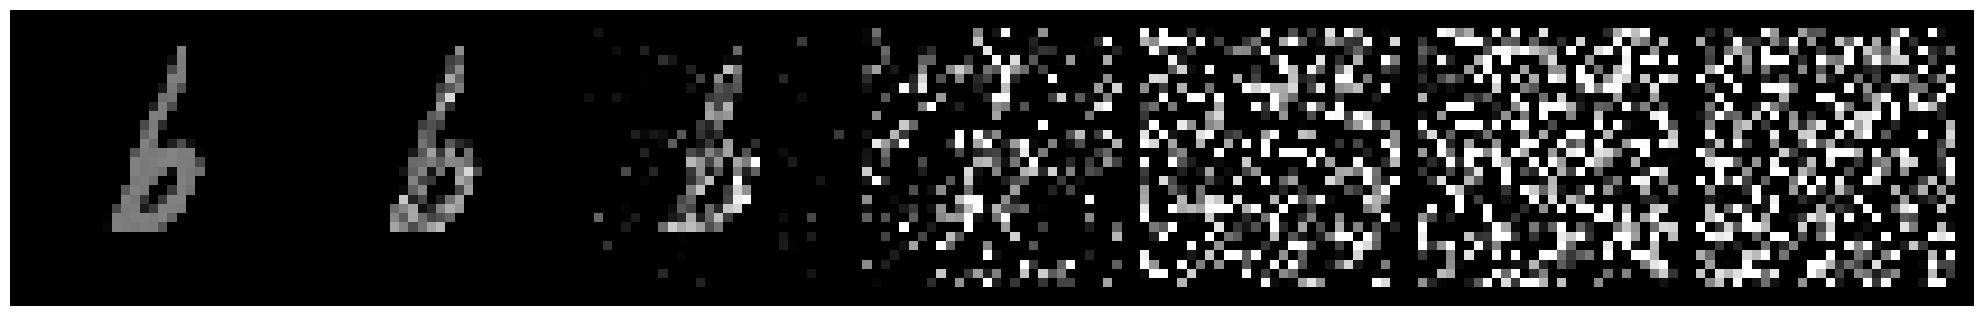

In [14]:
# Test
for x, _ in train_dataloader:
    break

# Plot degradation process for an example image
with torch.no_grad():
    x_first = x[0].unsqueeze(0)
    t_list = [0,50,100,250,500,750,999]
    noisy_images = []
    for t in t_list:
        noisy_image = ddpm.forward_show(t, x_first)
        noisy_images.append(noisy_image)
        print(f"t={t} -> alpha_t={ddpm.alpha_t[t]}")
    noisy_images_tensor = torch.cat(noisy_images, dim=0)
    noisy_images_tensor = noisy_images_tensor.to(x.device)
    noisy_images_grid = make_grid(noisy_images_tensor, nrow=len(t_list), padding=2, normalize=False)
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(noisy_images_grid.permute(1, 2, 0).cpu())
    plt.show()

## Training Loop

In [15]:
# Define number of epochs and initialis losses
n_epoch = 75
training_losses = []
validation_losses = []

# Directory to save checkpoints and losses
act_string = str(activation).split('.')[-1].split('\'')[0]
base_directory_path = f"../contents/RUN_cnn-nh{n_hidden}-act{act_string}_ddpm-b{betas}-nt{n_T}_lr{learning_rate}"
directory_path = base_directory_path
counter = 1
while os.path.exists(directory_path):
    directory_path = f"{base_directory_path}({counter})"
    counter += 1
os.makedirs(directory_path, exist_ok=True)

# Training and Validation
try:
    # Training Loop
    for epoch in range(n_epoch):
        ddpm.train()
        batch_losses = []  
        print(f"Epoch {epoch+1}/{n_epoch}")
        pbar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epoch} - Training")
        for x, _ in pbar_train:
            x = x.to(accelerator.device)
            optim.zero_grad()
            loss = ddpm(x)
            accelerator.backward(loss)
            batch_losses.append(loss.item())
            optim.step()
            avg_loss = np.average(batch_losses)
            pbar_train.set_description(f"Training loss: {avg_loss:.3g}")

        training_losses.append(np.mean(batch_losses)) 

        # Validation Loop
        ddpm.eval()
        batch_val_losses = []
        pbar_val = tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{n_epoch} - Validation")
        with torch.no_grad():
            for x_val, _ in pbar_val:
                x_val = x_val.to(accelerator.device)
                val_loss = ddpm(x_val)
                batch_val_losses.append(val_loss.item())
                avg_val_loss = np.average(batch_val_losses)
                pbar_val.set_description(f"Validation loss: {avg_val_loss:.3g}")

        validation_losses.append(np.mean(batch_val_losses))
        
        # Save model weights after each epoch
        checkpoint_path = os.path.join(directory_path, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save(ddpm.state_dict(), checkpoint_path)

        # Generate and save sample images after every epoch
        with torch.no_grad():
            xh = ddpm.sample(16, (1, 28, 28), accelerator.device)
            grid = make_grid(xh, nrow=4)
            save_image(grid, f"{directory_path}/sample_{epoch:04d}.png")

except KeyboardInterrupt:
    print("Training interrupted. Saving progress...")
    print(base_directory_path)
    pass
finally:
    # Save losses and final model
    np.save(f"{directory_path}/training_losses.npy", np.array(training_losses))
    np.save(f"{directory_path}/validation_losses.npy", np.array(validation_losses))
    final_model_path = os.path.join(directory_path, "final_model.pth")
    torch.save(ddpm.state_dict(), final_model_path)
    print("Checkpoint and losses saved.")

Epoch 1/5


Validation loss: 0.0586: 100%|██████████| 94/94 [00:05<00:00, 16.86it/s]


Epoch 2/5


Training loss: 0.0504:  87%|████████▋ | 325/375 [00:28<00:04, 11.21it/s]

Training interrupted. Saving progress...
Checkpoint and losses saved.


## Performance Metrics

### Training and Validation Loss Curves

In [18]:
# Directoy of the contents
directory_path = '../contents'

if os.path.exists(directory_path):
    print("Contents of the directory:")
    for item in os.listdir(directory_path):
        print(item)
else:
    print(f"No such directory: {directory_path}")

Contents of the directory:
RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001(3)
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001(9)
.DS_Store
RUN_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.1, 0.8)-nt200_lr0.001
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.1, 0.8)-nt120_lr0.001
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.25)-nt120_lr0.0005
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001(12)
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001(11)
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001(7)
SALTPEPPER_cnn-nh(32, 64, 128, 256, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt60_lr0.001
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495)-nt200_lr0.001
SALTPEPPER_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.05, 0.495

Average training loss: 0.02143858782141595
Average validation loss: 0.021337184582260138
Final training loss: 0.01802604385217031
Final validation loss: 0.018474471626525865
Minimum validation loss: 0.017652459125569526
Epoch of minimum validation loss: 68


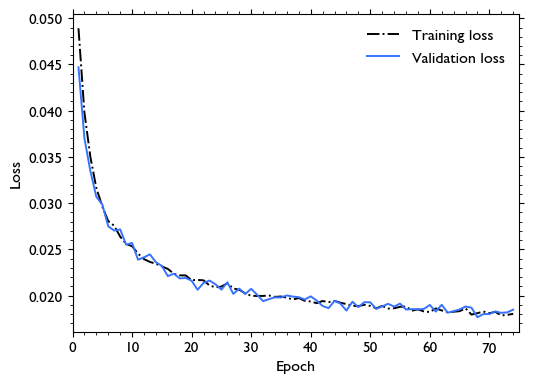

In [91]:
# Select Run to load (copy paste from above)
run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"

# Load the losses
training_losses = np.load(f"../contents/{run_name}/training_losses.npy")[1:]
validation_losses = np.load(f"../contents/{run_name}/validation_losses.npy")[1:]

# Visualize the losses
plt.figure(figsize=(5.5, 4))
plt.plot(range(1,75),training_losses, label="Training loss", linestyle = '-.', color = 'black')
plt.plot(range(1,75),validation_losses, label="Validation loss", color=sd2022_blue)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0,75)
plt.legend()
print("Average training loss:", np.mean(training_losses))
print("Average validation loss:", np.mean(validation_losses))
print("Final training loss:", training_losses[-1])
print("Final validation loss:", validation_losses[-1])
print("Minimum validation loss:", np.min(validation_losses))
print("Epoch of minimum validation loss:", np.argmin(validation_losses)+1)



### FID Score 

In [78]:
try:
    # Get real images
    real_images_list = []
    images_needed = 100
    for images, _ in train_dataloader:
        real_images_list.append(images.to(accelerator.device))
        if sum(len(images) for images in real_images_list) >= images_needed:
            break  
    real_images = torch.cat(real_images_list, dim=0)[:images_needed]

    # Load the model 
    run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"
    epochs = [10, 68, 75]

    def get_fake_images(epoch, run_name):
        """Get generated images from the model at a specific epoch.
        """
        ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1200)
        checkpoint_path = f'../contents/{run_name}/checkpoint_epoch_{epoch}.pth'
        model = torch.load(checkpoint_path)
        # Get fake images
        with torch.no_grad():
            ddpm.load_state_dict(model)
            ddpm.to('cpu')
            fake_images = ddpm.sample(images_needed, (1, 28, 28), device='cpu')
        return fake_images

    # Calculate the FID score
    def calculate_fid_score(real_images, fake_images):
        """Calculate the FID score between real and generated images.
        """
        # Prepare the images
        real_images_rgb, fake_images_rgb = real_images.repeat(1, 3, 1, 1), fake_images.repeat(1, 3, 1, 1)
        real_images_rgb, fake_images_rgb = real_images_rgb.to('cpu'), fake_images_rgb.to('cpu')
        real_images_rgb, fake_images_rgb = (real_images_rgb + 0.5) / (torch.max(real_images_rgb) - torch.min(real_images_rgb)), (fake_images_rgb - torch.min(fake_images_rgb)) / (torch.max(fake_images_rgb) - torch.min(fake_images_rgb))
        real_images_rgb = real_images_rgb.float() 
        fake_images_rgb = fake_images_rgb.float()
        # Calculate FID score
        with torch.no_grad():
            fid = FrechetInceptionDistance(normalize=True)
            for i in range(10):
                batch_real = real_images_rgb[i*10:(i+1)*10].float()  
                batch_fake = fake_images_rgb[i*10:(i+1)*10].float() 
                if batch_real.size(0) > 0 and batch_fake.size(0) > 0:
                    fid.update(batch_real, real=True)
                    fid.update(batch_fake, real=False)
        print(f"FID: {float(fid.compute())}")
        return float(fid.compute())

    # Save FID scores
    fid_scores = []
    for epoch in epochs:
        fake_images = get_fake_images(epoch, run_name)
        fid_score = calculate_fid_score(real_images, fake_images)
        fid_scores.append(fid_score)

    df_fid = pd.DataFrame(fid_scores, columns=["FID score"], index=epochs)
    df_fid.to_csv(f"../contents/{run_name}/fid_scores.csv")

except KeyboardInterrupt:
    print("Interrupted.")
    pass

Interrupted.


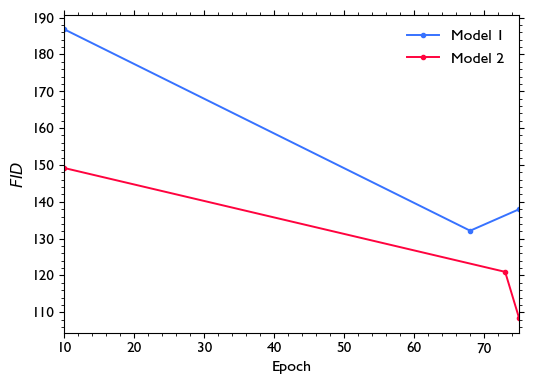

In [79]:
# Load the FID scores
run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"
run_name2 = "RUN_cnn-nh(32, 64, 128, 64, 32)-actGELU_ddpm-b(0.0001, 0.05)-nt1200_lr0.001"
df_fid = pd.read_csv(f"../contents/{run_name}/fid_scores.csv", index_col=0)
df_fid2 = pd.read_csv(f"../contents/{run_name2}/fid_scores.csv", index_col=0)

# Visualize the FID scores
plt.figure(figsize=(5.5, 4))
plt.plot(df_fid, marker='.', color=sd2022_blue, label = 'Model 1')
plt.plot(df_fid2, marker='.', color=sd2022_red, label = 'Model 2')
plt.xlabel("Epoch")
plt.ylabel(r'$FID$')
plt.legend()
plt.show()



### IS Score

In [80]:
# Define the CNN classifier
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x  

model = CNN()
model.to(accelerator.device)

# Load the CNN classifier
cnn_model_name = "../classifier_models/cnn_classifier4.pth"
state_dict = torch.load(cnn_model_name, map_location=accelerator.device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [81]:
try:
    # Define DDPM
    run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"
    ep = 68

    # Generate samples
    def generate_images(epoch, run_name, n_images):
        """Sample images from the model at a specific epoch."""
        ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
        checkpoint_path = f'../contents/{run_name}/checkpoint_epoch_{epoch}.pth'
        model = torch.load(checkpoint_path)
        # Get fake images
        with torch.no_grad():
            ddpm.load_state_dict(model)
            ddpm.to(accelerator.device)
            images = ddpm.sample(n_images, (1, 28, 28), device=accelerator.device)
        return images

    images = generate_images(ep, run_name, 1000)
    images100 = images[:100]
    images_grid = make_grid(images100, nrow=10, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(images_grid.permute(1, 2, 0).cpu())


    # Predict labels for the images
    def predict_labels(images, model):
        """Predict labels for the images using the CNN classifier."""
        model.eval()
        images = images.to(accelerator.device)
        with torch.no_grad():
            test_output, last_layer = model(images)
            predicted = torch.max(test_output, 1)[1].data.squeeze()
        return predicted, last_layer

    predicted_labels, last_layer = predict_labels(images, model)
    predicted_labels = predicted_labels.cpu()
    last_layer = last_layer.cpu()

    # Save the predicted labels
    df = pd.DataFrame(predicted_labels.numpy(), columns=["Predicted labels"])
    df.to_csv(f"../contents/{run_name}/predicted_labels.csv")

    # Save the last layer predictions
    np.save(f"../contents/{run_name}/last_layer.npy", last_layer.numpy())

    # Clear existing directories and save images in new directories based on predicted labels
    for i in range(10):
        dir_path = f"../contents/{run_name}/predicted_labels/{i}"
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    # Save images in folders depending on prediction
    for i in range(1000):
        save_image(images[i].unsqueeze(0), f"../contents/{run_name}/predicted_labels/{predicted_labels[i]}/{i}.png")

except KeyboardInterrupt:
    print("Interrupted.")
    pass


Interrupted.


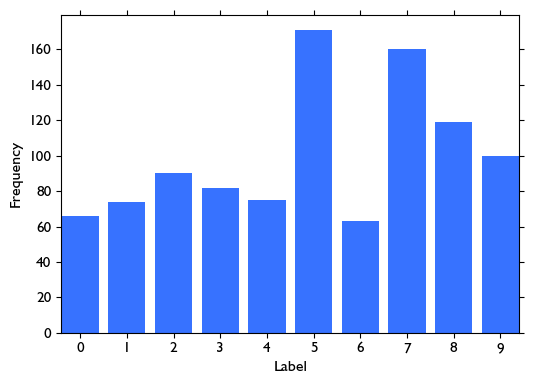

In [82]:
# Load the predicted labels
df = pd.read_csv(f"../contents/{run_name}/predicted_labels.csv")
predicted_labels = df["Predicted labels"].values

# Plot prediction histogram
label_freq = [np.sum(predicted_labels == i) for i in range(10)]
plt.figure(figsize=(5.5, 4))
plt.bar(range(10), label_freq, color=sd2022_blue)
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.minorticks_off()
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [90]:
# Inception Score function
def inception_score_from_preds(preds, splits=10):
    """Calculate the Inception Score from precomputed predictions."""
    scores = []
    N = preds.shape[0]
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(entropy(part, py, base=np.e, axis=1)))) 
    return np.mean(scores), np.std(scores)

# Load the inception predictions
inception_preds = np.load(f"../contents/{run_name}/last_layer.npy")
logits = torch.tensor(inception_preds)  # Convert to a PyTorch tensor if not already
probs = torch.nn.functional.softmax(logits, dim=1).numpy()  # Apply softmax and convert back to numpy

# Calculate the Inception Score
inception_score, inception_std = inception_score_from_preds(probs)
print(f"Inception Score: {inception_score:.3f} ± {inception_std:.3f}")

Inception Score: 4.588 ± 0.152


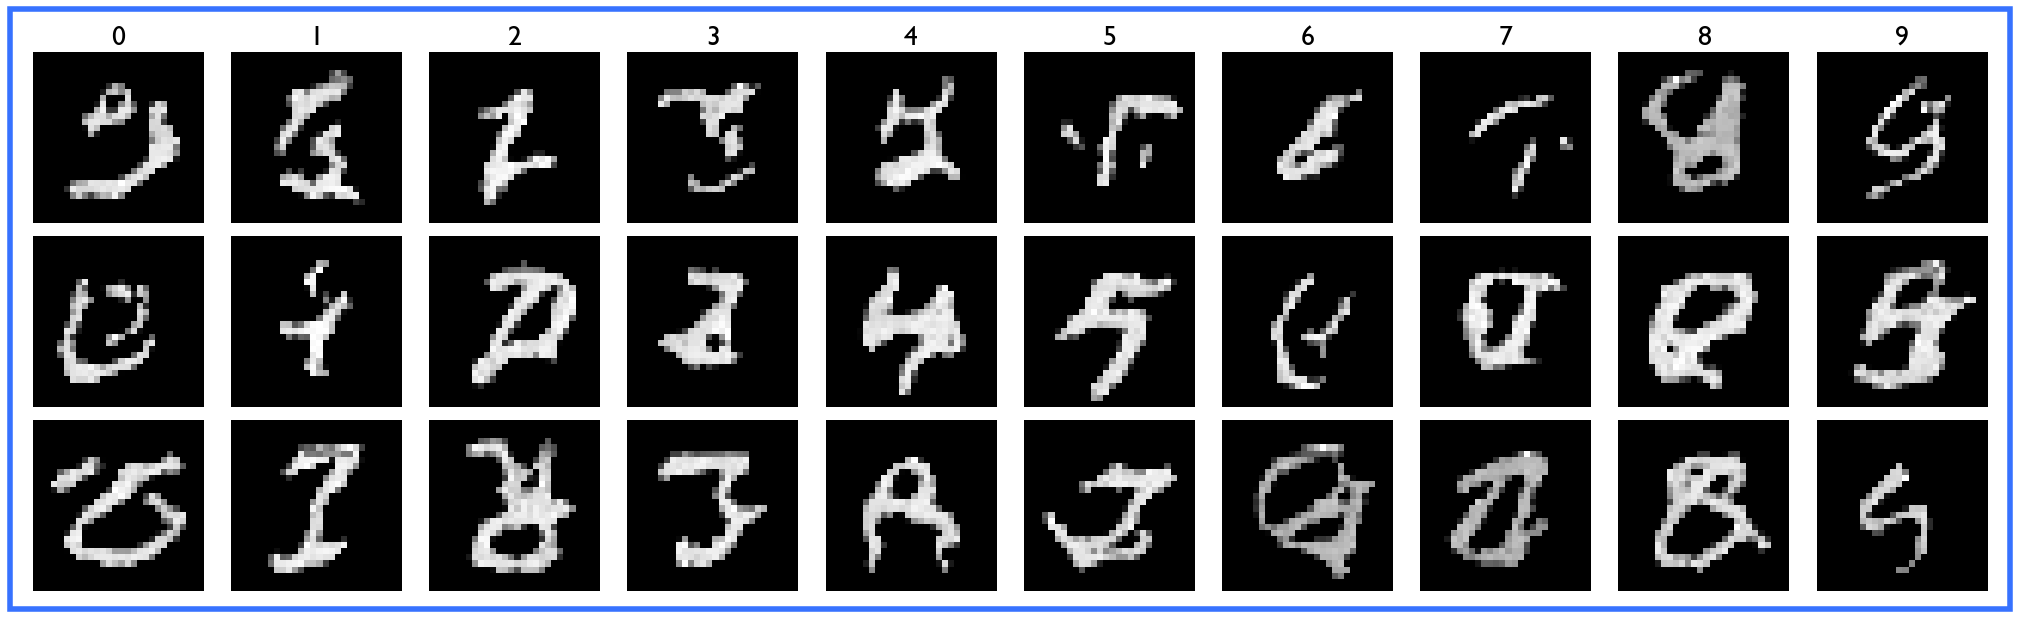

In [100]:
# Display 3 images for each digit

run_name = "RUN_cnn-nh(16, 32, 32, 16)-actGELU_ddpm-b(0.0001, 0.02)-nt1000_lr0.0002(4)"
base_path = f"../contents/{run_name}/predicted_labels"

n_digits = 10  
n_images_per_digit = 3

fig, axes = plt.subplots(n_images_per_digit, n_digits, figsize=(n_digits * 2, n_images_per_digit * 2))

for digit in range(n_digits):
    digit_path = os.path.join(base_path, str(digit))
    image_files = sorted(os.listdir(digit_path))[:n_images_per_digit]
    
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(digit_path, image_file)
        img = mpimg.imread(img_path)

        if img.ndim == 3 and img.shape[2] in [3, 4]:
            img = img.mean(axis=-1)

        if i == 0:
            axes[i,digit].set_title(digit, fontsize = 20)
        
        axes[i, digit].imshow(img, cmap='gray')
        axes[i, digit].axis('off') 

plt.tight_layout()
rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor=sd2022_blue, facecolor='none', transform=fig.transFigure, clip_on=False)
fig.patches.append(rect)
plt.show()